In [3]:
# Pseudo-code for 1F1B schedule with Algorithm 1 vocabulary parallelism

# Let's define operations:
# "F{i}(M)" = Forward pass of transformer layers on Stage i, microbatch M.
# "S(M)" = Forward computation of output layer (softmax, etc.)
# "T(M)" = Backward computation part of output layer
# "B{i}(M)" = Backward pass of transformer layers on Stage i, microbatch M.

def generate_1F1B_vp_schedule(num_stages, microbatches, vp_stage):
    """
    num_stages: number of pipeline stages
    microbatches: list of microbatch ids, e.g. [1, 2, ...]
    vp_stage: which stage holds the vocabulary parallel (assume last stage)
    """
    # For simplicity, assume we have only one microbatch.
    # A real schedule would "fill and drain" the pipeline, interleaving microbatches.
    M = microbatches[0]

    schedule = {stage: [] for stage in range(1, num_stages+1)}

    # In a typical 1F1B:
    # Stage i: F_i(M) followed by B_i(M)
    # For the stage with vocab parallelism (vp_stage), we insert S(M) and T(M) before B.
    for stage in range(1, num_stages+1):
        # Forward pass
        schedule[stage].append(f"F{stage}(M{M})")

        if stage == vp_stage:
            # Insert S(M) and T(M)
            schedule[stage].append(f"S(M{M})")
            schedule[stage].append(f"T(M{M})")

        # Backward pass
        schedule[stage].append(f"B{stage}(M{M})")

    return schedule

# Example usage:
num_stages = 4
microbatches = [1, 2, 3, 4, 5, 6, 7, 8]
vp_stage = 2  # The last stage holds the vocab parallel passes
schedule = generate_1F1B_vp_schedule(num_stages, microbatches, vp_stage)

# Print the schedule
for stage in schedule:
    print(f"Stage {stage}: " + " -> ".join(schedule[stage]))


Stage 1: F1(M1) -> B1(M1)
Stage 2: F2(M1) -> S(M1) -> T(M1) -> B2(M1)
Stage 3: F3(M1) -> B3(M1)
Stage 4: F4(M1) -> B4(M1)


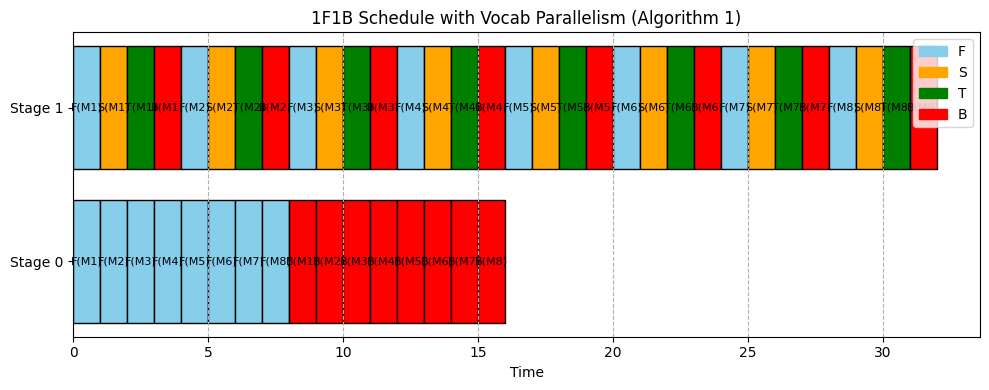

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Let's define the pipeline stages and tasks
num_stages = 4
num_microbatches = 8

# For simplicity, assume each task (F, S, T, B) takes one unit of time.
# We'll generate a schedule for Stage 1 (the last stage), including vocab passes.

schedule = []
current_time = 0

# Stage 0 (no vocab parallelism changes, just F and B):
for mb in range(num_microbatches):
    # Forward on Stage 0
    schedule.append((current_time, 0, f"F(M{mb+1})"))
    current_time += 1

for mb in range(num_microbatches):
    # Backward on Stage 0
    schedule.append((current_time, 0, f"B(M{mb+1})"))
    current_time += 1

# Reset time for Stage 1 to demonstrate scheduling:
current_time = 0
schedule_stage1 = []

for mb in range(num_microbatches):
    # Forward of transformer layers
    schedule_stage1.append((current_time, 1, f"F(M{mb+1})"))
    current_time += 1

    # Vocab S pass (after F)
    schedule_stage1.append((current_time, 1, f"S(M{mb+1})"))
    current_time += 1

    # Vocab T pass (after S)
    schedule_stage1.append((current_time, 1, f"T(M{mb+1})"))
    current_time += 1

    # Backward of transformer layers (after T)
    schedule_stage1.append((current_time, 1, f"B(M{mb+1})"))
    current_time += 1

# Combine schedules (in reality these run in parallel)
schedule.extend(schedule_stage1)

# Convert to a DataFrame for easier plotting:
df = pd.DataFrame(schedule, columns=["time", "stage", "task"])
df = df.sort_values(["stage","time"])

# Let's create a Gantt-like chart
fig, ax = plt.subplots(figsize=(10,4))
colors = {
    'F': 'skyblue', 
    'S': 'orange', 
    'T': 'green', 
    'B': 'red'
}

for i, row in df.iterrows():
    start = row['time']
    ax.barh(row['stage'], 1, left=start, color=colors[row['task'][0]], edgecolor='black')
    ax.text(start + 0.5, row['stage'], row['task'], ha='center', va='center', color='black', fontsize=8)

# Legend
patches = [mpatches.Patch(color=color, label=label) 
           for label, color in [('F','skyblue'), ('S','orange'), ('T','green'), ('B','red')]]
ax.legend(handles=patches, loc='upper right')

ax.set_yticks([0,1])
ax.set_yticklabels(["Stage 0", "Stage 1"])
ax.set_xlabel("Time")
ax.set_title("1F1B Schedule with Vocab Parallelism (Algorithm 1)")
plt.grid(True, axis='x', linestyle='--')
plt.tight_layout()
plt.show()


In [9]:
def generate_1F1B_vp_schedule(num_stages, microbatches):
    """
    Generate a naive 1F1B schedule with vocabulary parallelism distributed across all stages.
    Each stage i for each microbatch M does:
        F_i(M) -> S_i(M) -> T_i(M) -> B_i(M)
    This is a simplified example for demonstration purposes.
    """
    schedule = {stage: [] for stage in range(1, num_stages+1)}
    current_end_time = {stage: 0 for stage in range(1, num_stages+1)}
    F_done = {}

    for M in microbatches:
        # Forward passes across stages
        for stage in range(1, num_stages+1):
            start_time = current_end_time[stage]
            if stage > 1:
                # Wait for previous stage's forward on the same microbatch to finish
                while (stage-1, M, 'F') not in F_done:
                    pass
                start_time = max(start_time, F_done[(stage-1, M, 'F')])
            
            # F_i(M)
            schedule[stage].append((start_time, f"F{stage}(M{M})"))
            end_time = start_time + 1
            F_done[(stage, M, 'F')] = end_time
            current_end_time[stage] = end_time

        # S, T, B for each stage
        for stage in range(1, num_stages+1):
            # S_i(M)
            start_time = current_end_time[stage]
            # Must be after F_i(M)
            start_time = max(start_time, F_done[(stage, M, 'F')])
            schedule[stage].append((start_time, f"S{stage}(M{M})"))
            end_time = start_time + 1
            current_end_time[stage] = end_time

            # T_i(M)
            start_time = current_end_time[stage]
            schedule[stage].append((start_time, f"T{stage}(M{M})"))
            end_time = start_time + 1
            current_end_time[stage] = end_time

            # B_i(M)
            start_time = current_end_time[stage]
            schedule[stage].append((start_time, f"B{stage}(M{M})"))
            end_time = start_time + 1
            current_end_time[stage] = end_time

    return schedule

# Example usage:
num_stages = 4
microbatches = [1, 2, 3, 4, 5, 6, 7, 8]  # multiple microbatches
schedule = generate_1F1B_vp_schedule(num_stages, microbatches)

# Determine the global max time
max_time = 0
for stage in schedule:
    for (t, _) in schedule[stage]:
        max_time = max(max_time, t)

max_time += 5  # add a bit of spacing if needed

# Build a lookup for what each stage does at each time
stage_ops_by_time = {stage: {t: "" for t in range(max_time)} for stage in schedule}
for stage in schedule:
    for (t, op) in schedule[stage]:
        stage_ops_by_time[stage][t] = op

# Print column timeline
# Each column represents a time step.
header = "Time  " + "  ".join([f"Stage{st}" for st in sorted(schedule.keys())])
print(header)
print("-" * len(header))

for t in range(max_time):
    row_ops = [stage_ops_by_time[st][t] for st in sorted(schedule.keys())]
    # Only print rows that have some activity or are within the actual schedule range
    if any(row_ops) or t < max_time:
        ops_str = "  ".join(op if op else " " * len("StageX") for op in row_ops)
        print(f"{t:4d}  {ops_str}")

Time  Stage1  Stage2  Stage3  Stage4
------------------------------------
   0  F1(M1)                        
   1  S1(M1)  F2(M1)                
   2  T1(M1)  S2(M1)  F3(M1)        
   3  B1(M1)  T2(M1)  S3(M1)  F4(M1)
   4  F1(M2)  B2(M1)  T3(M1)  S4(M1)
   5  S1(M2)  F2(M2)  B3(M1)  T4(M1)
   6  T1(M2)  S2(M2)  F3(M2)  B4(M1)
   7  B1(M2)  T2(M2)  S3(M2)  F4(M2)
   8  F1(M3)  B2(M2)  T3(M2)  S4(M2)
   9  S1(M3)  F2(M3)  B3(M2)  T4(M2)
  10  T1(M3)  S2(M3)  F3(M3)  B4(M2)
  11  B1(M3)  T2(M3)  S3(M3)  F4(M3)
  12  F1(M4)  B2(M3)  T3(M3)  S4(M3)
  13  S1(M4)  F2(M4)  B3(M3)  T4(M3)
  14  T1(M4)  S2(M4)  F3(M4)  B4(M3)
  15  B1(M4)  T2(M4)  S3(M4)  F4(M4)
  16  F1(M5)  B2(M4)  T3(M4)  S4(M4)
  17  S1(M5)  F2(M5)  B3(M4)  T4(M4)
  18  T1(M5)  S2(M5)  F3(M5)  B4(M4)
  19  B1(M5)  T2(M5)  S3(M5)  F4(M5)
  20  F1(M6)  B2(M5)  T3(M5)  S4(M5)
  21  S1(M6)  F2(M6)  B3(M5)  T4(M5)
  22  T1(M6)  S2(M6)  F3(M6)  B4(M5)
  23  B1(M6)  T2(M6)  S3(M6)  F4(M6)
  24  F1(M7)  B2(M6)  T3(M6)  S4(M6)
 